<a href="https://colab.research.google.com/github/joynaomi81/English-French-Machine-Translation-Project/blob/main/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

In [ ]:
!pip install transformers datasets sacrebleu sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 12.3 MB/s eta 0:00:00


In [ ]:
# load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/damo_mt_testsets_en2fr_news_wmt13.csv")
df.head()


,0,1
0,Spectacular Wingsuit Jump Over Bogota,"Spectaculaire saut en ""wingsuit"" au-dessus de ..."
1,Sportsman Jhonathan Florez jumped from a helic...,Le sportif Jhonathan Florez a sauté jeudi d'un...
2,"Wearing a wingsuit, he flew past over the famo...",Equipé d'un wingsuit (une combinaison munie d'...
3,A black box in your car?,Une boîte noire dans votre voiture ?
4,As America's road planners struggle to find th...,Alors que les planificateurs du réseau routier...


In [ ]:
df.shape

(3003, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       3003 non-null   object
 1   1       3003 non-null   object
dtypes: object(2)
memory usage: 47.1+ KB


In [ ]:
# Rename columns
df = df.rename(columns={'0': 'english', '1': 'french'})

In [ ]:
df.head()

,english,french
0,Spectacular Wingsuit Jump Over Bogota,"Spectaculaire saut en ""wingsuit"" au-dessus de ..."
1,Sportsman Jhonathan Florez jumped from a helic...,Le sportif Jhonathan Florez a sauté jeudi d'un...
2,"Wearing a wingsuit, he flew past over the famo...",Equipé d'un wingsuit (une combinaison munie d'...
3,A black box in your car?,Une boîte noire dans votre voiture ?
4,As America's road planners struggle to find th...,Alors que les planificateurs du réseau routier...


In [ ]:
#Check for missing values
df.isnull().sum()

,0
english,0
french,0


In [ ]:
df.duplicated().sum()

np.int64(0)

Text Preprocessing

In [ ]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)     # remove HTML tags
    text = re.sub(r'\s+', ' ', text)        # remove extra spaces
    text = text.strip()                     # trim spaces
    return text

df['english'] = df['english'].apply(clean_text)
df['french'] = df['french'].apply(clean_text)
df.head()

,english,french
0,Spectacular Wingsuit Jump Over Bogota,"Spectaculaire saut en ""wingsuit"" au-dessus de ..."
1,Sportsman Jhonathan Florez jumped from a helic...,Le sportif Jhonathan Florez a sauté jeudi d'un...
2,"Wearing a wingsuit, he flew past over the famo...",Equipé d'un wingsuit (une combinaison munie d'...
3,A black box in your car?,Une boîte noire dans votre voiture ?
4,As America's road planners struggle to find th...,Alors que les planificateurs du réseau routier...


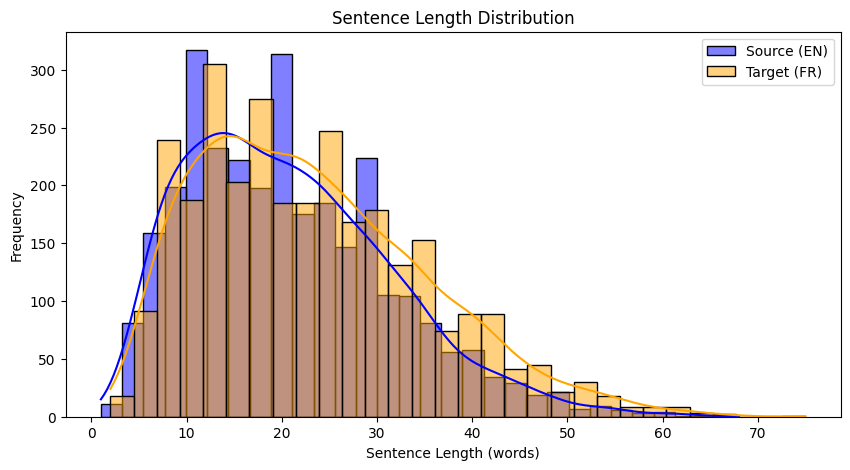

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df['src_len'] = df['english'].apply(lambda x: len(str(x).split()))
df['tgt_len'] = df['french'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['src_len'], bins=30, color='blue', kde=True, label='Source (EN)')
sns.histplot(df['tgt_len'], bins=30, color='orange', kde=True, label='Target (FR)')
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.legend()
plt.show()

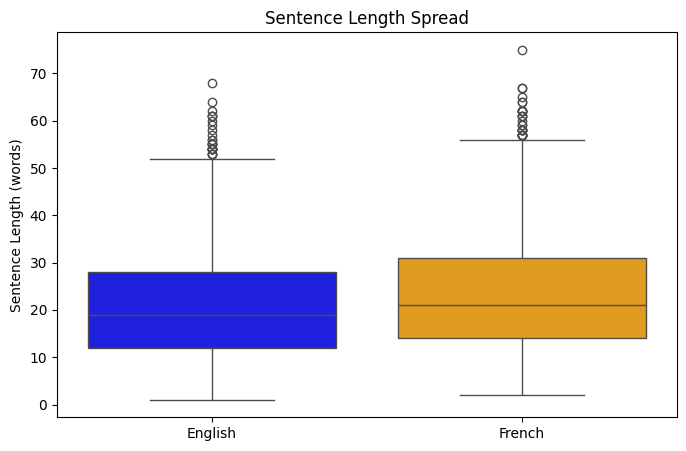

In [ ]:
#Boxplot for sentence length spread
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['src_len', 'tgt_len']], palette=['blue', 'orange'])
plt.xticks([0, 1], ['English', 'French'])
plt.ylabel("Sentence Length (words)")
plt.title("Sentence Length Spread")
plt.show()


In [ ]:
# Check for unique values
df.nunique()

,0
english,3003
french,3003
src_len,64
tgt_len,65


In [ ]:
sources = df['english'].tolist()      # English sentences
references_str = df['french'].tolist()  # French reference sentences

In [ ]:
from transformers import MBart50TokenizerFast, MBartForConditionalGeneration

model_name = "facebook/mbart-large-50-many-to-many-mmt"

tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

tokenizer.src_lang = "en_XX"  # Set source language to English

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [ ]:
!pip install tqdm


In [ ]:
sources_3003 = sources[:3003]

In [ ]:
from tqdm import tqdm
batch_size = 16
predictions = []

for i in tqdm(range(0, len(sources_3003), batch_size)):
    batch_sentences = sources_3003[i:i+batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True)

    # Generate translations
    generated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["fr_XX"],
        max_length=100
    )

    # Decode and add to predictions list
    batch_translations = [tokenizer.decode(t, skip_special_tokens=True) for t in generated_tokens]
    predictions.extend(batch_translations)


100%|██████████| 188/188 [1:32:13<00:00, 29.44s/it]


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
from evaluate import load # Corrected import

In [ ]:

import evaluate


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=08b6b28cf6bcbc6fabe1c4733a22fa42c34adb83a76b340ff4e55af21517e8af
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate

# Slice the references to match sources_3003
references_3003_raw = references_str[:3003]       # list of strings
references_3003 = [[ref] for ref in references_3003_raw]  # list of lists for BLEU

# BLEU
bleu = evaluate.load("bleu")
bleu_results = bleu.compute(predictions=predictions, references=references_3003)
print("BLEU Score:", bleu_results["bleu"])

# ROUGE
rouge = evaluate.load("rouge")
rouge_results = rouge.compute(predictions=predictions, references=references_3003_raw)
print("ROUGE:", rouge_results)

# METEOR
meteor = evaluate.load("meteor")
meteor_results = meteor.compute(predictions=predictions, references=references_3003_raw)
print("METEOR Score:", meteor_results["meteor"])


BLEU Score: 0.35353379587174233
ROUGE: {'rouge1': np.float64(0.64539979604085), 'rouge2': np.float64(0.44355625438978397), 'rougeL': np.float64(0.6089930988596879), 'rougeLsum': np.float64(0.6088508792270437)}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


METEOR Score: 0.6162778678218186


In [ ]:
import pandas as pd

# Create a DataFrame for inspection
sample_df = pd.DataFrame({
    "English Source": sources[:10],               # first 10 English sentences
    "Model Prediction": predictions[:10],         # first 10 predictions
    "Reference Translation": references_str[:10]  # first 10 reference translations
})

# Display
sample_df


,English Source,Model Prediction,Reference Translation
0,Spectacular Wingsuit Jump Over Bogota,Spectacular Wingsuit Jump Over Bogota,"Spectaculaire saut en ""wingsuit"" au-dessus de ..."
1,Sportsman Jhonathan Florez jumped from a helic...,Le sportif Jhonathan Florez a sauté d'un hélic...,Le sportif Jhonathan Florez a sauté jeudi d'un...
2,"Wearing a wingsuit, he flew past over the famo...",Il a survolé à 160 km/h le célèbre sanctuaire ...,Equipé d'un wingsuit (une combinaison munie d'...
3,A black box in your car?,Une boîte noire dans votre voiture?,Une boîte noire dans votre voiture ?
4,As America's road planners struggle to find th...,Alors que les planificateurs routiers américai...,Alors que les planificateurs du réseau routier...
5,"The devices, which track every mile a motorist...",Les dispositifs qui suivent chaque milles parc...,"Les appareils, qui enregistrent tous les miles..."
6,The usually dull arena of highway planning has...,L'arène habituellement ténue de la planificati...,Le secteur généralement sans intérêt de la pla...
7,Libertarians have joined environmental groups ...,Les libertariens se sont joints à des groupes ...,Les libertaires ont rejoint des groupes écolog...
8,The tea party is aghast.,La fête du thé est effrayée.,Le Tea Party est atterré.
9,The American Civil Liberties Union is deeply c...,L'Union américaine des libertés civiles est ég...,L'American Civil Liberties Union est elle auss...
